__The goal of analysis is to try to figure out how JetBrainds customers react to Jetbrains products on Twitter (negative? positive? What products are mentioned most often? is there a difference between them?)__

In [1]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# hypothesis testing
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

# visualization
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# tweets parcing and preparing
import snscrape.modules.twitter as sntwitter # parcing
from textblob import TextBlob # polarity assessment
import re # clearing tweets
from googletrans import Translator # translating to English

import locationtagger # to extract cities and countries from tweet
from geopy.geocoders import Nominatim # to find country by city
import pycountry # to plot world map
import geopandas # to plot world map

# ignore warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# time processing
import datetime

# progress bar
from tqdm.auto import tqdm

pd.set_option('display.max_colwidth', None) # to show entire text of the tweet

%matplotlib inline

___
**Collect all tweets mentioned JetBrains or JB products from the beginning of the current year**

Some tweets have already been collected before, so let's load this data to determine the last saved tweet. Then let's scrape, process and add all new tweets to the existing dataframe

In [2]:
# prepare list of tags (in lower case)
jb_titles = ['jetbrains', 'webstormide', 'golandide', 'jetbrains_edu', 'appcode', 'rubymine', 
             'datagrip', 'dotcover', 'youtrack', 'upsource_jb', 'jetbrains_fleet', 'intellijidea', 
             'jbplatform', 'phpstorm', 'dotpeek', 'jbtoolbox', 'resharper_cpp', 'jetbrainsktor',
             'dottrace', 'dotmemory', 'jetbrainsrider', 'jetbrains_space', 'resharper', 'jetbrains_hub',
             'clion_ide', 'pycharm', 'teamcity', 'jetbrains_mps', 'datalore', 'qodana', 'dataspell_jb',
             'bigdatatools', 'projectorjb', 'jetbrains_cwm', 'jetbrainsqa', 'grazie']

# path to file with old tweets. They will be concatenated with recently posted tweets
path_to_save = 'tweets_mentioned_JB.csv'

Read old tweets to find out the date of the last saved twitter 

In [3]:
# try to read old tweets and find the date of last tweet
try: # if DF exists
    # read
    jb_tweets = pd.read_csv(path_to_save, sep=',', index_col=0, parse_dates=['date_created'])
    
    # determine date of the last tweet
    target_date = str(jb_tweets.sort_values('date_created', ascending=False).date_created.dt.date.max())
except: # if not
    # create empty DF instead of
    jb_tweets = pd.DataFrame()
    
    # save the begin of year as target date
    target_date = '2022-01-01'

Let's parse all new tweets starting from target date

Since the official Twitter API does not allow parsing tweets for a long period of time, let's use TwitterSearchScraper

In [4]:
# fuction for parcing
def parce_tweets(target_tags, start_date):
    
    tweets = pd.DataFrame()
    
    for tweet_tag in target_tags:
        # create list to append tweet data to
        attributes_container = []

        # use TwitterSearchScraper to scrape data and append tweets to list
        # get independent tweets, not replies

        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'@{tweet_tag} since:{start_date} -filter:replies') \
                                  .get_items()):
            
            # add a column with English translation for further tweet polarity assesment
            translator = Translator()
            translated_tweet = translator.translate(tweet.rawContent)
            
            # add a column with the mentioned tag
            attributes_container.append([tweet.id,
                                         tweet.user.username.lower(),
                                         tweet.user.location,
                                         tweet.date, 
                                         tweet.likeCount,
                                         tweet.replyCount,
                                         tweet.retweetCount,
                                         tweet.sourceLabel, 
                                         tweet.rawContent,
                                         translated_tweet.text,
                                         tweet.lang,
                                         tweet_tag])

        # create a dataframe to load the list
        temp_df = pd.DataFrame(attributes_container, columns=["tweet_id", 
                                                              "user_name",
                                                              "user_location",
                                                              "date_created", 
                                                              "likes_count",
                                                              "replies_count",
                                                              "retweets_count",
                                                              "platform", 
                                                              "original_tweet",
                                                              "translated_tweet",
                                                              "language",
                                                              "tag"])
        # concatinate df with all tags
        tweets = pd.concat([tweets, temp_df]).reset_index(drop=True)
        
    return tweets

In [5]:
# parce new tweets from new target date
new_tweets = parce_tweets(jb_titles, target_date)

In [6]:
# check DF size
new_tweets.shape

(33, 12)

In [7]:
# check missing values
new_tweets.isna().sum()

tweet_id            0
user_name           0
user_location       0
date_created        0
likes_count         0
replies_count       0
retweets_count      0
platform            0
original_tweet      0
translated_tweet    0
language            0
tag                 0
dtype: int64

On Twitter, the user himself can indicate his location if desired. Therefore, the user location may contain missing values, as well as the titiles of non-existent cities and countries. Therefore, for further analysis, let's use the location parsing libraries to determine right user's country, if possible

In [8]:
def country_detect(location):    
    try:
        # find location by geocode, return English title
        geolocator = Nominatim(user_agent = "geoapiExercises")
        country = geolocator.geocode(location,  language='en')
        
         # country is listed last in the address
        return country.address.split(',')[-1].strip()
    except:
        return 'undefined'

In [9]:
# apply country detection function
new_tweets['country'] = new_tweets.loc[~new_tweets.user_location.isna()].user_location.apply(country_detect)
new_tweets.country = new_tweets.country.fillna('undefined')

Assess the polarity of tweets using textblob. Polarity is rated between -1 and 1, where -1 is strong negative and 1 is strong positive

In [10]:
# functions to assess tweet polarity using textblob

# tweet preparing 
def clean_tweet(tweet):
    # clean the text in a tweet by removing 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

# calculation of polarity score
def sentiment_score(tweet):
    # estimate polarity of tweet using textblob
    # -1 is strong negative, 1 is strong positive
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity

# polarity classification
def analize_sentiment(score):
    # [-1; 0) is negative, 0 is neutral and (0; 1] is positive 
    
    output = 'negative'
    
    if score > 0:
        output = 'positive'
    elif score == 0:
        output = 'neutral'
    return output

In [11]:
# estimate polarity
new_tweets['polarity_score'] = new_tweets.translated_tweet.apply(sentiment_score)
new_tweets['polarity'] = new_tweets.polarity_score.apply(analize_sentiment)

In [12]:
# concatenate both DF, save the result instead of jb_tweets and to the file for further processing
jb_tweets = pd.concat([jb_tweets, new_tweets], axis=0).drop_duplicates()
jb_tweets.to_csv(path_to_save)

The obtained dataset contains tweets published by JB accounts, as well as users. Save them separately

In [13]:
# save separately
jb = jb_tweets.loc[jb_tweets.user_name.isin(jb_tweets.tag)]
users = jb_tweets.loc[~jb_tweets.user_name.isin(jb_tweets.tag)]

---
**Find total number of negative, neutral, positive tweets. Analyze proportions**

In [14]:
all_tweets_polarity = users \
                    .drop_duplicates(subset=['tweet_id']) \
                    .groupby('polarity', as_index=False) \
                    .agg({'tweet_id': 'count', 'polarity_score': 'mean'}) \
                    .rename(columns={'tweet_id': 'count', 'polarity_score': 'mean_polarity_score'})
all_tweets_polarity['percent'] = round(all_tweets_polarity['count'] / all_tweets_polarity['count'].sum() * 100, 2)
all_tweets_polarity=all_tweets_polarity.reindex(columns=['polarity', 'count', 'percent', 'mean_polarity_score'])
all_tweets_polarity

polarity  count  percent  mean_polarity_score
0  negative    940    11.05            -0.198186
1   neutral   2844    33.43             0.000000
2  positive   4723    55.52             0.318432

We can see that negative tweets make up around 11 percent of the total, which is not a lot given the large number of JB products. We can also estimate the polarity degree for all tweets

In [15]:
users.polarity_score.describe()

count    9355.000000
mean        0.157983
std         0.253611
min        -1.000000
25%         0.000000
50%         0.100000
75%         0.302841
max         1.000000
Name: polarity_score, dtype: float64

25 percent of tweets has a polarity score from 0.3 to 1.

Let's plot polarity distribution

<AxesSubplot:xlabel='polarity_score', ylabel='Count'>

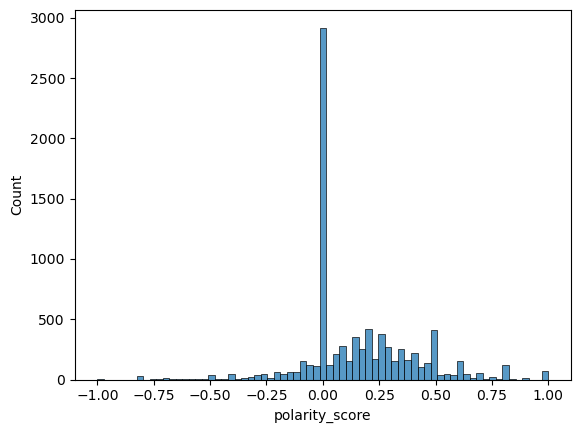

In [16]:
user_without_dublicates = users.drop_duplicates(subset=['tweet_id']).reset_index()
sns.histplot(data=user_without_dublicates, x="polarity_score")

A fairly large number of tweets have a neutral polarity. The polarity of the rest tweets is centered around the value of 0.25.

---
**Analyze polarity of tweets by JB product**

In [17]:
# calculate polarity by products
product_polarity = users.loc[users.tag != 'jetbrains'] \
        .groupby(['tag', 'polarity'], as_index=False) \
        .agg({'tweet_id': 'count'}) \
        .pivot(values='tweet_id', index='tag', columns='polarity') \
        .fillna(0) \
        .rename_axis(None, axis=1)

product_polarity['total'] = product_polarity.negative + product_polarity.neutral + product_polarity.positive

# leave only those for which there were at least 100 mentions
mentioned_products = product_polarity[product_polarity.total > 100].reset_index().sort_values('total', ascending=True)

<AxesSubplot:xlabel='value', ylabel='tag'>

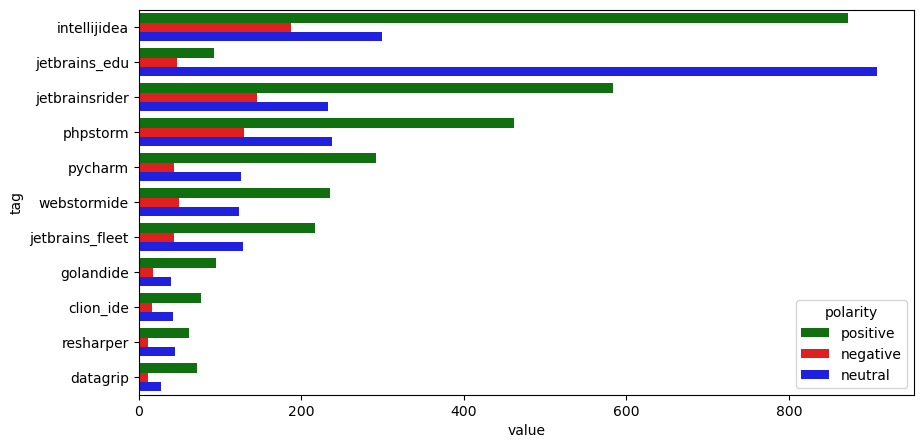

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(
            data=mentioned_products.melt(id_vars=["tag", "total"], var_name="polarity").sort_values('total', ascending=False), 
            x="value",
            y="tag",
            hue="polarity",
            orient="h",
            palette=["green", "red", "blue"])

The biggest product of JetBrains, intellijidea, is mentioned most often, as well as jetbrains_edu.

In [19]:
mentioned_products.sort_values('negative', ascending=False)

tag  negative  neutral  positive   total
3      intellijidea     188.0    299.0     873.0  1360.0
6    jetbrainsrider     145.0    233.0     584.0   962.0
7          phpstorm     130.0    238.0     462.0   830.0
10      webstormide      50.0    123.0     235.0   408.0
4     jetbrains_edu      47.0    908.0      93.0  1048.0
8           pycharm      44.0    126.0     292.0   462.0
5   jetbrains_fleet      43.0    128.0     217.0   388.0
2         golandide      18.0     40.0      95.0   153.0
0         clion_ide      17.0     42.0      77.0   136.0
1          datagrip      12.0     28.0      72.0   112.0
9         resharper      11.0     45.0      62.0   118.0

In absolute terms, the most negative tweets are dedicated to intellijidea. Let's rate all products relative to the number of product mentions

In [20]:
mentioned_products = mentioned_products.set_index('tag')

In [21]:
# find interest
round((mentioned_products[['negative', 'neutral', 'positive']] \
                 .div(mentioned_products.total, axis=0) * 100) \
                .sort_values(['negative'], ascending=False), 2)

negative  neutral  positive
tag                                         
phpstorm            15.66    28.67     55.66
jetbrainsrider      15.07    24.22     60.71
intellijidea        13.82    21.99     64.19
clion_ide           12.50    30.88     56.62
webstormide         12.25    30.15     57.60
golandide           11.76    26.14     62.09
jetbrains_fleet     11.08    32.99     55.93
datagrip            10.71    25.00     64.29
pycharm              9.52    27.27     63.20
resharper            9.32    38.14     52.54
jetbrains_edu        4.48    86.64      8.87

The negative tweets percentage for most of products ranges between 9 and 16, while more than half of all tweets are positive, excluding jetbrains_edu (neutral). My guess is that neutral tweets are defined as jetbrains_edu mentions in various educational projects and in the partner promotions.

The proportions of negative, neutral, and positive tweets about webstormide and jetbrains_fleet seem close. Is there a statistical difference?

Text(0.5, 0, 'polarity score')

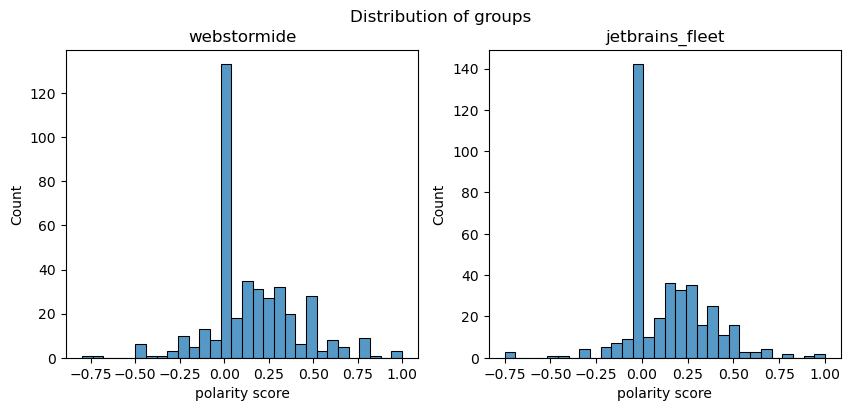

In [22]:
# plot distributions
fig, axes = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Distribution of groups')

sns.histplot(data=users.loc[users.tag == 'webstormide'], x="polarity_score", ax=axes[0], bins=30)
axes[0].set_title('webstormide')
axes[0].set_xlabel("polarity score")
sns.histplot(data=users.loc[users.tag == 'jetbrains_fleet'], x="polarity_score", ax=axes[1], bins=30)
axes[1].set_title('jetbrains_fleet')
axes[1].set_xlabel("polarity score")

The distributions look similar, but not close to normal

In [23]:
# check normality excluding neutral tweets
stats.normaltest(users.loc[(users.tag == 'webstormide') & (users.polarity != 'neutral')].polarity_score)

NormaltestResult(statistic=8.950582945605666, pvalue=0.011386902668334954)

In [24]:
stats.normaltest(users.loc[(users.tag == 'jetbrains_fleet') & (users.polarity != 'neutral')].polarity_score)

NormaltestResult(statistic=24.485559870620285, pvalue=4.819791272451166e-06)

Even after excluding neutral tweets, a T-test cannot be used to detemine difference as significance. Let's use custom bootstrap function

In [25]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

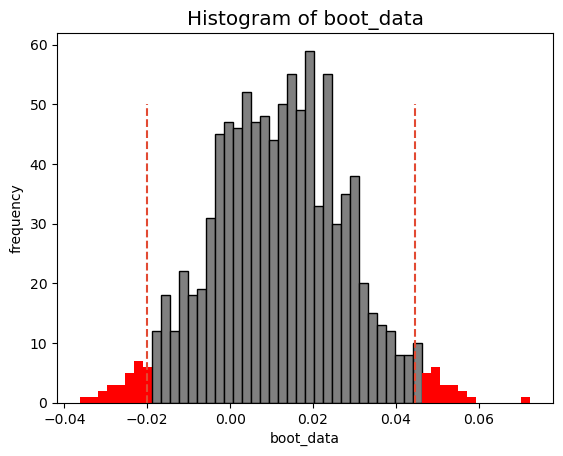

In [26]:
webstorm = users.loc[(users.tag == 'webstormide')].polarity_score
fleet = users.loc[(users.tag == 'jetbrains_fleet')].polarity_score
booted_data = get_bootstrap(webstorm, fleet)

In [27]:
booted_data["p_value"] 

0.46741177046814875

In [28]:
booted_data["quants"]

0
0.025 -0.020009
0.975  0.044652

The probability value is too large to reject the hypothesis of similar distributions.

Let's also check hypothesis using library bootstrap

In [29]:
webstorm = np.array(users.loc[(users.tag == 'webstormide')].polarity_score)
fleet = np.array(users.loc[(users.tag == 'jetbrains_fleet')].polarity_score)

print(bs.bootstrap_ab(webstorm, fleet, bs_stats.mean, bs_compare.percent_change))

8.066660540842838    (-20.46405319056885, 30.603440956434625)


The confidence interval includes 0, so there is no reason to reject the hypothesis about the similarity of distributions

---
**Analyze tweets by country**

In [30]:
# calculate tweets by country and polarity 
tweets_by_country = users.loc[users.country != 'undefined'][['tweet_id', 'country', 'polarity']] \
                .drop_duplicates(subset=['tweet_id'])
tweets_by_country_polarity = tweets_by_country.groupby(['country', 'polarity'], as_index=False).agg({'tweet_id': 'count'}) \
                             .pivot(index='country', columns='polarity', values='tweet_id') \
                             .fillna(0).reset_index().sort_values(['negative', 'neutral', 'positive'], ascending=False)

In [31]:
tweets_by_country_polarity.head(20)

polarity         country  negative  neutral  positive
132        United States     112.0    280.0     659.0
48               Germany      95.0    171.0     343.0
131       United Kingdom      90.0    140.0     419.0
46                France      41.0     88.0     159.0
58                 India      25.0     86.0     159.0
16               Belgium      23.0     23.0     123.0
86           Netherlands      22.0     49.0     111.0
22                Brazil      20.0     77.0      76.0
35               Czechia      19.0     13.0      43.0
115                Spain      17.0     52.0     102.0
100               Poland      14.0     56.0      79.0
8              Australia      14.0     37.0      61.0
64                 Italy      12.0     44.0      58.0
27                Canada      12.0     38.0      78.0
104               Russia      11.0     32.0      33.0
9                Austria      11.0     15.0      41.0
129              Ukraine      10.0     31.0      49.0
37               Denmark      10.0     17.0      35.0
87           New Zealand       9.0     21.0      29.0
62               Ireland       8.0      9.0      18.0

In [32]:
tweets_by_country_polarity.tail(20)

polarity                           country  negative  neutral  positive
80                               Mauritius       0.0      0.0       3.0
124                                   Togo       0.0      0.0       3.0
10                              Azerbaijan       0.0      0.0       2.0
21                                Botswana       0.0      0.0       2.0
25                                Cambodia       0.0      0.0       2.0
26                                Cameroon       0.0      0.0       2.0
36        Democratic Republic of the Congo       0.0      0.0       2.0
126                                Tunisia       0.0      0.0       2.0
137                                 Zambia       0.0      0.0       2.0
11                                 Bahrain       0.0      0.0       1.0
41                             El Salvador       0.0      0.0       1.0
88                               Nicaragua       0.0      0.0       1.0
91                         North Macedonia       0.0      0.0       1.0
93                                    Oman       0.0      0.0       1.0
96                                  Panama       0.0      0.0       1.0
105                                 Rwanda       0.0      0.0       1.0
108                           Sierra Leone       0.0      0.0       1.0
112                                Somalia       0.0      0.0       1.0
117                                  Sudan       0.0      0.0       1.0
120                                  Syria       0.0      0.0       1.0

Most of the tweets are published by users from America, Europe, New Zealand, Brazil, India, Russia and Ukraine. The fewest tweets are from African users, but they are all positive :)

Let's plot them on the world map

In [33]:
tweets_by_country = tweets_by_country \
                    .groupby('country', as_index=False) \
                    .agg({'tweet_id': 'count'}) \
                    .rename(columns={'tweet_id': 'tweet_numbers'}) \
                    .sort_values('tweet_numbers', ascending=False)
# fix Russia title
tweets_by_country = tweets_by_country.replace('Russia', 'Russian Federation')

In [34]:
# function to find country code
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [35]:
# find country code
tweets_by_country['CODE'] = alpha3code(tweets_by_country.country)

In [36]:
# merge DF with worldmap DF
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ['pop_est', 'continent', 'name', 'CODE', 'gdp_md_est', 'geometry']
merge = pd.merge(world,tweets_by_country,on='CODE')

In [37]:
# get location of each country
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
merge = merge.merge(location, on='name').reset_index()

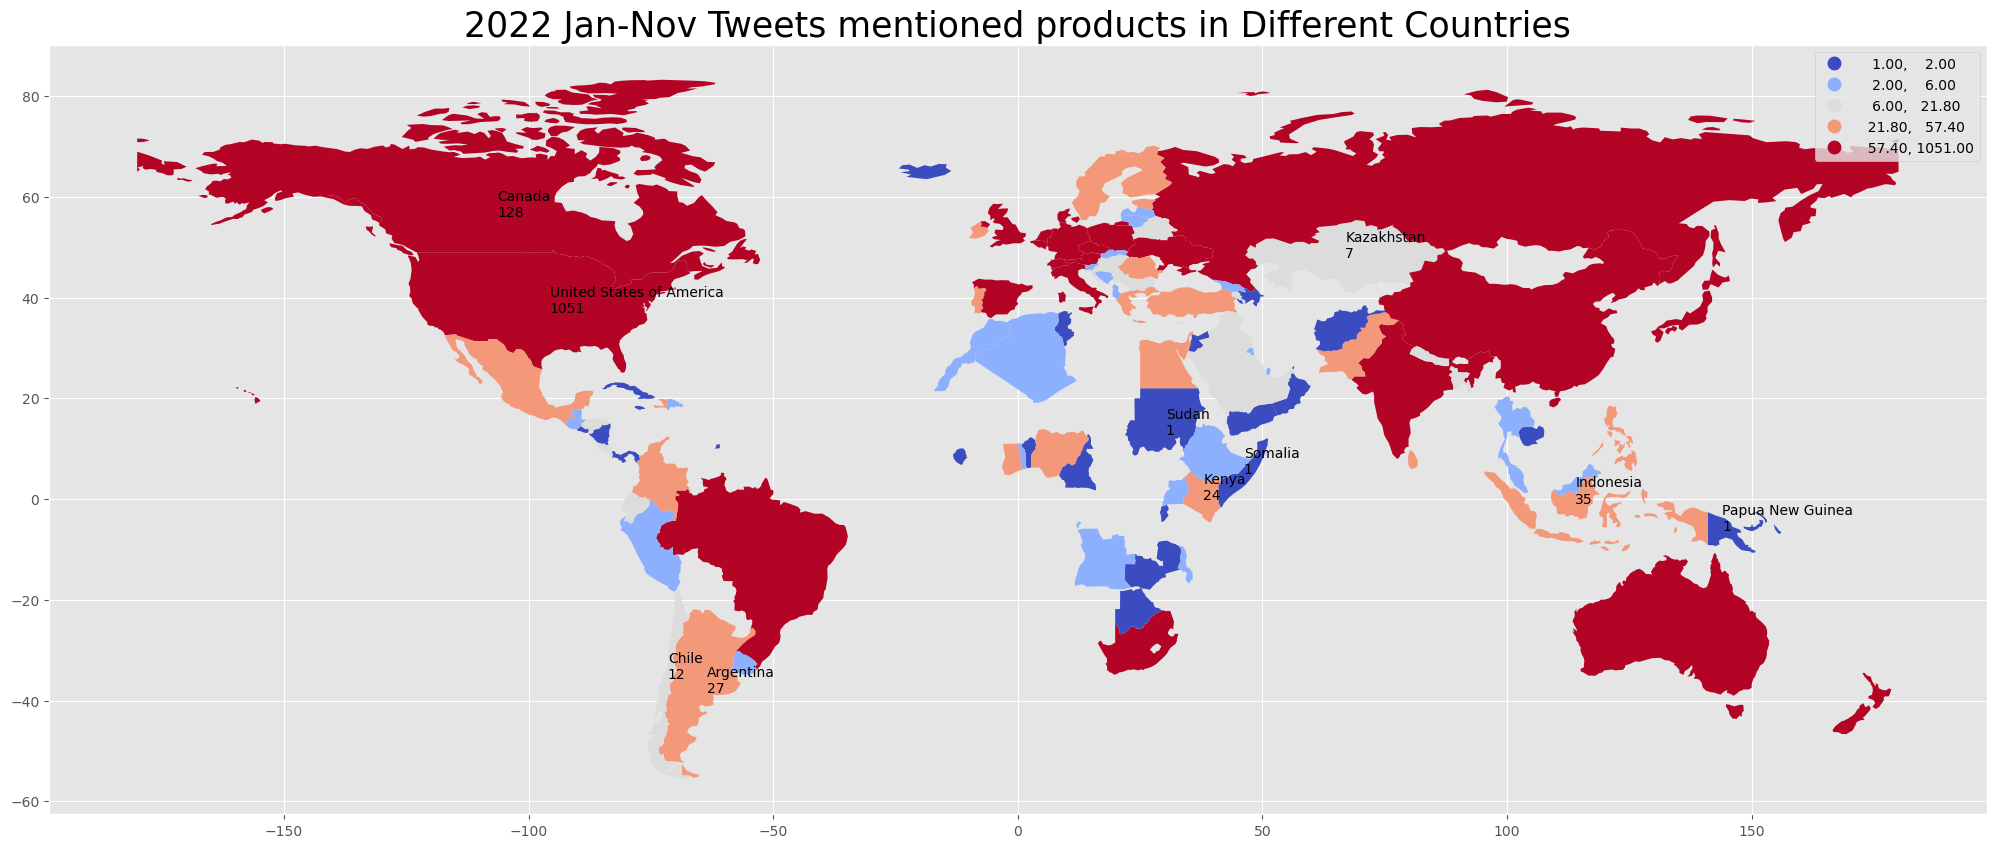

In [38]:
merge.plot(column='tweet_numbers', scheme="quantiles",
           figsize=(25, 25),
           legend=True,cmap='coolwarm')
plt.title('2022 Jan-Nov Tweets mentioned products in Different Countries',fontsize=25)

for i in range(0,10):
    plt.text(float(merge.longitude[i]),float(merge.latitude[i]),"{}\n{}".format(merge.name[i],merge.tweet_numbers[i]),size=10)

to be continued...